In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable as V

In [4]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        #super(Linear,self).__init__() #等价于
        nn.Module.__init__(self)
        self.w = nn.Parameter(t.randn(in_features,out_features))
        self.b = nn.Parameter(t.randn(out_features))
        
    def forward(self, x):
        x = x.mm(self.w)
        return x+self.b.expand_as(x)


In [5]:
layer = Linear(4,3)
input = V(t.randn(2,4))
output = layer(input)
output

tensor([[ 2.0108,  1.1530,  0.5550],
        [ 1.9244,  1.3663, -0.6627]], grad_fn=<AddBackward0>)

In [6]:
for name, para in layer.named_parameters():
    print(name,para)# w and b

w Parameter containing:
tensor([[ 1.8479, -0.3475,  1.3414],
        [-0.3303,  0.2335,  0.3046],
        [ 1.9106,  0.2666,  0.5314],
        [-0.6765, -0.1278, -0.0273]], requires_grad=True)
b Parameter containing:
tensor([1.2291, 1.2474, 0.2014], requires_grad=True)


In [10]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        nn.Module.__init__(self)
        self.layer1 = Linear(in_features, hidden_features)
        self.layer2 = Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

perceptron = Perceptron(3,4,1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])


Conv: 1D, 2D, 3D 
Pool: AvgPool, MaxPool, AdaptiveAvgPool

TransposeConv

In [22]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor() # img to tensor
to_pil = ToPILImage()
lena = Image.open('imgs/lena.jpg')
lena = lena.convert('L')

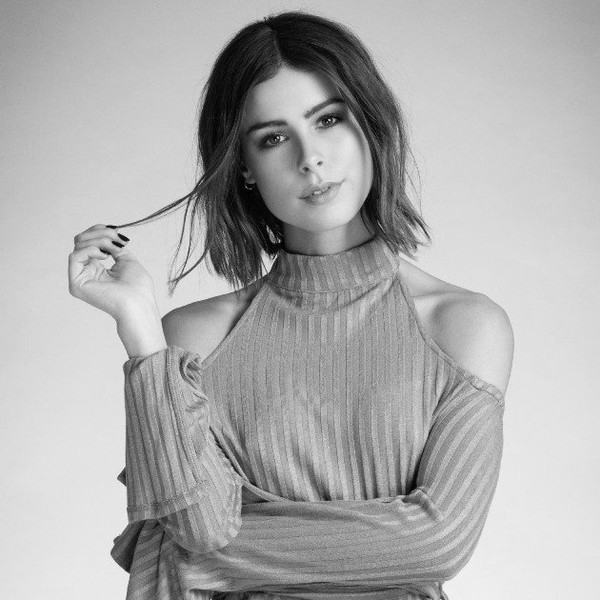

In [23]:
lena

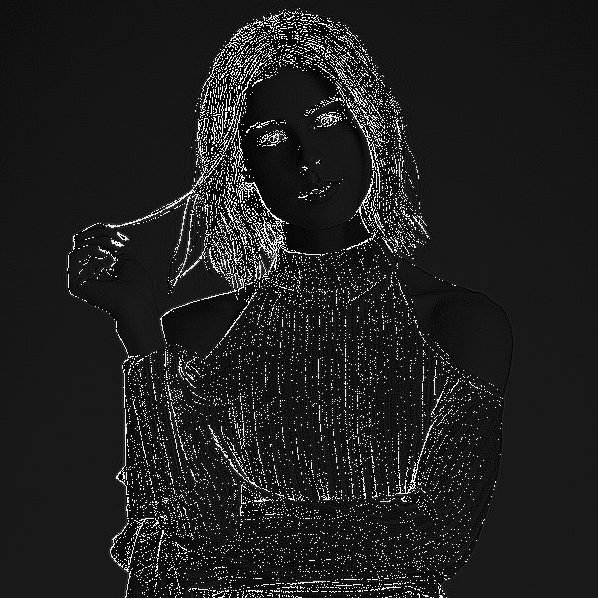

In [24]:
input = to_tensor(lena).unsqueeze(0)

#锐化卷积核
kernel = t.ones(3,3)/-9
kernel[1][1] = 1
conv = nn.Conv2d(1,1,(3,3),1,bias=False)
conv.weight.data = kernel.view(1,1,3,3)

out = conv(V(input))
to_pil(out.data.squeeze(0))

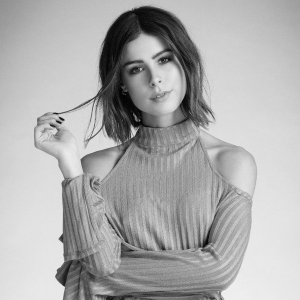

In [25]:
pool = nn.AvgPool2d(2,2)
list(pool.parameters())

out = pool(V(input))
to_pil(out.data.squeeze(0))

In [26]:
input = V(t.randn(2,3))
linear = nn.Linear(3,4)
h =linear(input)
h

tensor([[ 0.1166, -0.5010, -0.1287, -1.0701],
        [ 0.3567,  0.6122,  0.1621, -0.2149]], grad_fn=<AddmmBackward>)

In [28]:
# 4 channels
#批规范化层
bn = nn.BatchNorm1d(4) #标准差为4
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
bn_out.mean(0), bn_out.var(0,unbiased=False)


(tensor([1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        grad_fn=<MeanBackward2>),
 tensor([15.9889, 15.9995, 15.9924, 15.9991], grad_fn=<VarBackward1>))

In [29]:
#每个元素0.5概率舍弃，防止过拟合
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o

tensor([[-7.9972, -0.0000, -7.9981, -7.9998],
        [ 7.9972,  0.0000,  7.9981,  7.9998]], grad_fn=<MulBackward0>)

In [30]:
relu = nn.ReLU(inplace=True)
input = V(t.randn(2,3))
print(input)
output = relu(input)
print(output)

tensor([[-1.7392,  0.5197, -1.7560],
        [ 0.1639, -0.9287, -0.7886]])
tensor([[0.0000, 0.5197, 0.0000],
        [0.1639, 0.0000, 0.0000]])


对于前馈传播网络（上一层输出直接作为下一层输入），forward的两种简化方式：ModuleList和Sequential

In [39]:
#Sequential
net1 = nn.Sequential()
net1.add_module('conv',nn.Conv2d(3,3,3))
net1.add_module('batchnorm',nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(nn.Conv2d(3,3,3),
                    nn.BatchNorm2d(3),
                    nn.ReLU())

from collections import OrderedDict
net3 = nn.Sequential(OrderedDict([('conv1',nn.Conv2d(3,3,3)),
                                 ('bn1',nn.BatchNorm2d(3)),
                                 ('relu1',nn.ReLU())]))



print('net1: ', net1)
print('net2: ', net2)
print('net3: ', net3)

net1:  Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2:  Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3:  Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [40]:
input = t.rand(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net1.batchnorm(net1.conv(input)))

In [41]:

modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = t.randn(1, 3)
for model in modellist:
    input = model(input)
# 下面会报错,因为modellist没有实现forward方法
# output = modelist(input)

In [42]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [44]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


### RNN

In [47]:
t.manual_seed(1000)

input = V(t.randn(2,3,4)) # batch_size=3 序列长度为2, 序列中每个元素为四位

lstm = nn.LSTM(4,3,1) #思维，3个隐藏元，1层‘

#初始状态
h0 = V(t.randn(1,3,3))
c0 = V(t.randn(1,3,3))
out,hm = lstm(input, (h0,c0))
out

tensor([[[-0.3610, -0.1643,  0.1631],
         [-0.0613, -0.4937, -0.1642],
         [ 0.5080, -0.4175,  0.2502]],

        [[-0.0703, -0.0393, -0.0429],
         [ 0.2085, -0.3005, -0.2686],
         [ 0.1482, -0.4728,  0.1425]]], grad_fn=<StackBackward>)

In [49]:
embedding = nn.Embedding(4,5)

embedding.weight.data = t.arange(0,20).view(4,5)

In [50]:
input = V(t.arange(3,0,-1)).long()
output = embedding(input)
output

tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]], grad_fn=<EmbeddingBackward>)

## ResNet

In [61]:
from torch import  nn
import torch as t
from torch.nn import  functional as F

In [69]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
                                 nn.BatchNorm2d(outchannel),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                                 nn.BatchNorm2d(outchannel))
        self.right = shortcut
    
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)


class ResNet(nn.Module):
    #resnet34
    
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        #前几层图像转换
        self.pre = nn.Sequential(nn.Conv2d(3,64,7,2,3,bias=False),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(3,2,1))
        
        #重复的layer,分别有3,4,6,3个residual block
        self.layer1 = self._make_layer(64,128,3)
        self.layer2 = self._make_layer(128,256,4,stride=2)
        self.layer3 = self._make_layer(256,512,6,stride=2)
        self.layer4 = self._make_layer(512,512,3,stride=2)
        
        #分类用的全连接
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        #构建layer
        
        shortcut = nn.Sequential(nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
                                nn.BatchNorm2d(outchannel))
        layers = []
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x,7)
        x = x.view(x.size(0),-1)
        return self.fc(x)



In [70]:
model = ResNet()
input = t.autograd.Variable(t.randn(1,3,224,224))
o = model(input)

In [71]:
from torchvision import models
model = models.resnet34()